# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [34]:
# Carrega as bases lidas na tarefa passada
base_X_train = pd.read_csv('base_X_train.csv')
base_X_test = pd.read_csv('base_X_test.csv')

In [35]:
# considerar a leitura dos índices
base_X_train.set_index(['index', 'id'], inplace=True)
base_X_test.set_index(['index', 'id'], inplace=True)

In [36]:
# faz a leitura dos nomes das atividades
activity_labels = pd.read_csv('activity_labels.txt', delim_whitespace=True, header=None)
activity_labels = dict(activity_labels.to_dict(orient='split')['data'])

In [37]:
# faz a leitura da variável resposta
base_y_train = pd.read_csv('y_train.txt', header=None)
base_y_test = pd.read_csv('y_test.txt', header=None)

In [38]:
# substitui a ID da atividade pelo nome
base_y_train.replace(activity_labels, inplace=True)
base_y_test.replace(activity_labels, inplace=True)

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(base_X_train, base_y_train, test_size=0.25)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [40]:
# árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis
dtc = DecisionTreeClassifier(random_state=42, max_depth=4)
dtc.fit(base_X_train, base_y_train)

# recuperando o índice das variáveis mais relevantes
maiores_importancias = np.argsort(dtc.feature_importances_)[::-1]

# considerando as 3 variáveis com maior importância
maiores_importancias = maiores_importancias[:3]

# recuperando o nome das 3 variáveis com maior importância
variaveis_relevantes = [X_train.columns[indice] for indice in maiores_importancias]

variaveis_relevantes

['tGravityAcc-min()-X', 'tBodyAcc-std()-X', 'tGravityAcc-mean()-Y']

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [41]:
# construindo uma árvore de decisão para encontrar o melhor ccp_alpha
# usando apenas as 3 variáveis com maior importância

dtc = DecisionTreeClassifier(random_state=42)
path = dtc.cost_complexity_pruning_path(X_train[variaveis_relevantes], y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [42]:
%%time
classificadores = []
for ccp_alpha in ccp_alphas:
    classificador = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha)
    classificador.fit(X_train[variaveis_relevantes], y_train)
    classificadores.append(classificador)

CPU times: user 4.86 s, sys: 0 ns, total: 4.86 s
Wall time: 4.85 s


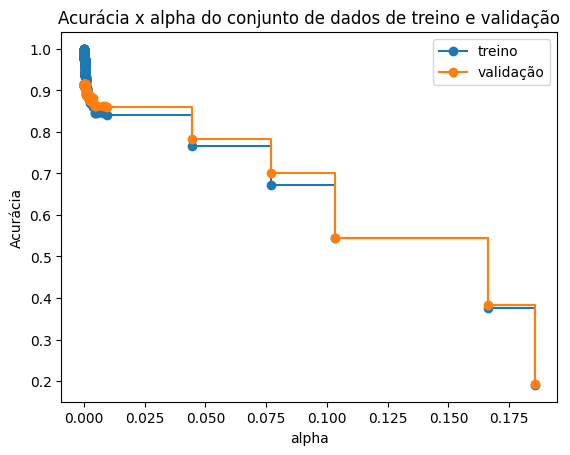

In [43]:
# buscando o melhor ccp_alpha utilizando a base de validação
# usando apenas as 3 variáveis com maior importância

train_scores = [classificador.score(X_train[variaveis_relevantes], y_train) for classificador in classificadores]
test_scores  = [classificador.score(X_valid[variaveis_relevantes], y_valid) for classificador in classificadores]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="validação", drawstyle="steps-post")
ax.legend()
plt.show()

In [44]:
ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = classificadores[ind_melhor_arvore]
acuracia = test_scores[ind_melhor_arvore]
alpha = ccp_alphas[ind_melhor_arvore]

In [45]:
print(f'Índice da melhor árvore: {ind_melhor_arvore}')
print(f'Acurácia: {acuracia}')
print(f'ccp alpha: {alpha}')

Índice da melhor árvore: 160
Acurácia: 0.9151251360174102
ccp alpha: 0.0004495051557075496


### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

In [46]:
# avaliando o modelo na base de teste com a melhor árvore, definida no passo anterior
# aqui também está usando apenas as 3 variáveis com maior importância

acuracia_teste = melhor_arvore.score(base_X_test[variaveis_relevantes], base_y_test)
print(f'Acurácia da base de teste: {acuracia_teste}')

Acurácia da base de teste: 0.7370206990159485


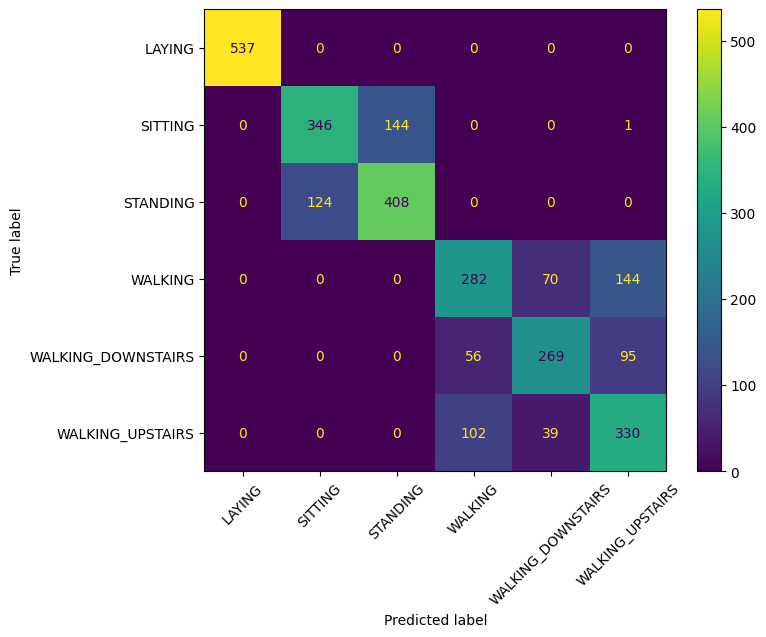

In [50]:
previsoes = melhor_arvore.predict(base_X_test[variaveis_relevantes])
cm = confusion_matrix(base_y_test, previsoes, labels=melhor_arvore.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=melhor_arvore.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax)
plt.xticks(rotation=45)
plt.show()